In [17]:
import datetime, os
import tensorflow as tf

from pathlib import Path
from matplotlib import pyplot as plt
from quickdraw import QuickDrawDataGroup, QuickDrawData

from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import sparse_categorical_accuracy
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization

from tensorflow.keras.callbacks import TensorBoard

In [18]:
image_size = (28, 28)

In [19]:
# image_size = (28, 28)

# def generate_class_images(name, max_drawings, recognized):
#     directory = Path("dataset/" + name)

#     if not directory.exists():
#         directory.mkdir(parents=True)

#     images = QuickDrawDataGroup(name, max_drawings=max_drawings, recognized=recognized)
#     for img in images.drawings:
#         filename = directory.as_posix() + "/" + str(img.key_id) + ".png"
#         img.get_image(stroke_width=3).resize(image_size).save(filename)

# for label in QuickDrawData().drawing_names:
#     generate_class_images(label, max_drawings=1200, recognized=True)

In [20]:
batch_size = 32

train_ds = image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="training",
    seed=123,
    color_mode="grayscale",
    image_size=image_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="validation",
    seed=123,
    color_mode="grayscale",
    image_size=image_size,
    batch_size=batch_size
)

Found 12000 files belonging to 10 classes.
Using 9600 files for training.
Found 12000 files belonging to 10 classes.
Using 2400 files for validation.


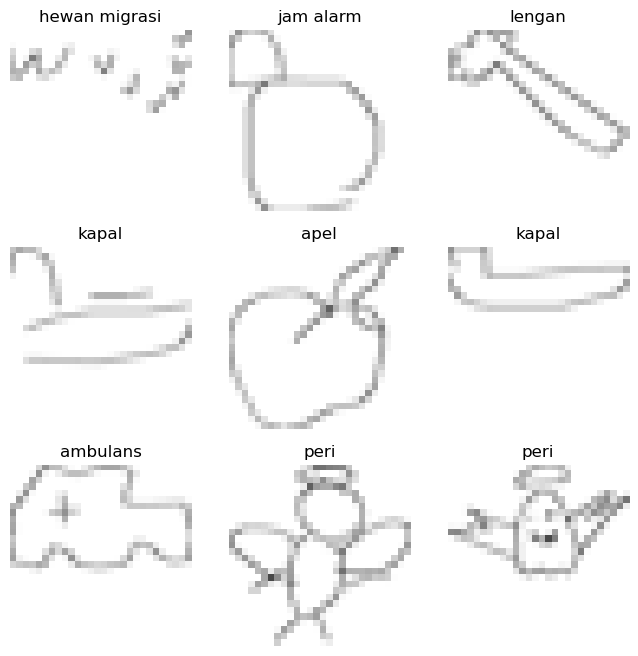

In [21]:
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        data = images[i].numpy().astype("uint8")
        plt.imshow(data, cmap='gray', vmin=0, vmax=255)
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

In [24]:
input_shape = (28, 28, 1)
n_classes = 10

model = Sequential([
    Rescaling(1. / 255, input_shape=input_shape),
    BatchNormalization(),

    Conv2D(6, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(8, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(10, kernel_size=(3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(700, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(500, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(400, activation='relu'),
    Dropout(0.2),

    Dense(n_classes, activation='softmax')
])

model.compile(
    optimizer="adam",
    loss=SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 28, 28, 1)         0         
                                                                 
 batch_normalization_28 (Ba  (None, 28, 28, 1)         4         
 tchNormalization)                                               
                                                                 
 conv2d_21 (Conv2D)          (None, 28, 28, 6)         60        
                                                                 
 conv2d_22 (Conv2D)          (None, 28, 28, 8)         440       
                                                                 
 conv2d_23 (Conv2D)          (None, 28, 28, 10)        730       
                                                                 
 batch_normalization_29 (Ba  (None, 28, 28, 10)        40        
 tchNormalization)                                    

In [25]:
epochs = 14

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[tensorboard_callback]
)

model.save('./models/model_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

Epoch 1/14
300/300 [==============================] - 18s 54ms/step - loss: 1.1613 - accuracy: 0.6356 - val_loss: 6.0742 - val_accuracy: 0.1150
Epoch 2/14
300/300 [==============================] - 9s 30ms/step - loss: 0.6108 - accuracy: 0.8069 - val_loss: 0.7210 - val_accuracy: 0.7833
Epoch 3/14
300/300 [==============================] - 9s 31ms/step - loss: 0.3868 - accuracy: 0.8731 - val_loss: 0.6558 - val_accuracy: 0.8204
Epoch 4/14
300/300 [==============================] - 9s 31ms/step - loss: 0.2882 - accuracy: 0.9032 - val_loss: 0.6027 - val_accuracy: 0.8404
Epoch 5/14
300/300 [==============================] - 9s 31ms/step - loss: 0.2244 - accuracy: 0.9237 - val_loss: 0.6121 - val_accuracy: 0.8558
Epoch 6/14
300/300 [==============================] - 9s 31ms/step - loss: 0.1954 - accuracy: 0.9321 - val_loss: 0.8058 - val_accuracy: 0.8246
Epoch 7/14
300/300 [==============================] - 9s 31ms/step - loss: 0.1687 - accuracy: 0.9411 - val_loss: 0.5533 - val_accuracy: 0.863

INFO:tensorflow:Assets written to: ./models/model_20231109-051401\assets


In [40]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Fungsi untuk memuat gambar dan melakukan prediksi
def predict_image(model, image_path):
    img = image.load_img(image_path, color_mode="grayscale", target_size=(28, 28))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Ubah dimensi untuk sesuai dengan input model (tambahkan dimensi batch)
    img_array = img_array / 255.0  # Normalisasi gambar

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)
    
    return predicted_class, predictions

# Path ke model yang telah Anda simpan
saved_model_path = './models/model_20231109-051401'  # Ganti dengan path yang sesuai

# Memuat model
loaded_model = tf.keras.models.load_model(saved_model_path)

# Path ke gambar yang ingin Anda prediksi
image_path = 'dataset/apel/4505772249579520.png'  # Ganti dengan path gambar yang ingin Anda prediksi

predicted_class, predictions = predict_image(loaded_model, image_path)

print("Predicted Class:", predicted_class)
print("Predictions:", predictions)


1/1 [==============================] - 0s 83ms/step
Predicted Class: 3
Predictions: [[3.1567171e-01 0.0000000e+00 5.6517037e-23 6.8432832e-01 1.8726246e-19
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]]


In [3]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# Fungsi untuk memuat gambar dan melakukan prediksi dengan model TFLite
def predict_image_tflite(tflite_model, image_path):
    interpreter = tf.lite.Interpreter(model_path=tflite_model)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Load and preprocess the image
    img = image.load_img(image_path, color_mode="grayscale", target_size=(28, 28))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    interpreter.set_tensor(input_details[0]['index'], img_array)
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    predicted_class = np.argmax(output_data)

    return predicted_class, output_data

# Path ke model yang telah Anda konversi menjadi TFLite
tflite_model_path = 'model.tflite'  # Ganti dengan path model TFLite yang sesuai

# Path ke gambar yang ingin Anda prediksi
image_path = '4504435055132672.png'  # Ganti dengan path gambar yang ingin Anda prediksi

predicted_class_tflite, predictions_tflite = predict_image_tflite(tflite_model_path, image_path)

print("Predicted Class (TFLite):", predicted_class_tflite)
print("Predictions (TFLite):", predictions_tflite)


Predicted Class (TFLite): 3
Predictions (TFLite): [[3.1667957e-01 0.0000000e+00 5.5122098e-23 6.8332046e-01 1.8196452e-19
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]]


In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("models/model_20231109-051401") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)